!sudo apt-get update
!apt-cache search libgl
!sudo apt-get install libgl1-mesa-glx -y

In [3]:
# basic
import time
import warnings
warnings.filterwarnings('ignore')

import os
import random
import itertools
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import jaccard_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

# PyTorch
import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch_pruning as tp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

# visualization
from PIL import Image
import matplotlib.pyplot as plt


In [4]:
class config:
    
    root = "/home/ttban9527/vinbigdata/train"
    num_classes = 14
    batch_size = 30
    epochs = 20
    weight_decay = 1e-6
    lr = 1e-4
    momentum = 0.9
    gamma = 0.1
    seed = 42
    att = "100"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
class NoOpAttacker():
    def attack(self, image, label, model):
        return image

class PGDAttacker():
    def __init__(self, num_iter, epsilon, step_size, device):
        self.num_iter = num_iter
        self.epsilon = epsilon / 255
        self.step_size = step_size / 255
        self.device = device

    def attack(self, image_clean, label, model):
        seed_everything(config.seed)
        # 設定上下界
        lower_bound = torch.clamp(image_clean - self.epsilon, min=-1., max=1.)
        upper_bound = torch.clamp(image_clean + self.epsilon, min=-1., max=1.)
        
        # 隨機初始化
        init_start = torch.empty_like(image_clean).uniform_(-self.epsilon, self.epsilon)
        adv = image_clean + init_start

        for _ in range(self.num_iter):
            adv.requires_grad = True
            logits = model(adv)
            losses = nn.BCEWithLogitsLoss()(logits, label)
            g = torch.autograd.grad(losses, adv, retain_graph=False, create_graph=False)[0]
            
            adv = adv + torch.sign(g) * self.step_size
            
            adv = torch.clamp(adv, min=lower_bound, max=upper_bound).detach()
        
        return adv


# Mixup可能不適用

from timm.data import Mixup
mixup_fn = None
mixup_active = args.mixup > 0 or args.cutmix > 0. or args.cutmix_minmax is not None
if mixup_active:
    mixup_fn = Mixup(
                mixup_alpha=config.mixup, cutmix_alpha=config.cutmix, cutmix_minmax=config.cutmix_minmax,
                prob=config.mixup_prob, switch_prob=config.mixup_switch_prob, mode=config.mixup_mode,
                label_smoothing=config.smoothing, num_classes=14)

class_id
14    10606
0      3067
3      2300
11     1981
13     1617
7      1322
9      1134
10     1032
8       826
6       613
2       452
5       386
4       353
1       186
12       96
Name: count, dtype: int64
25971


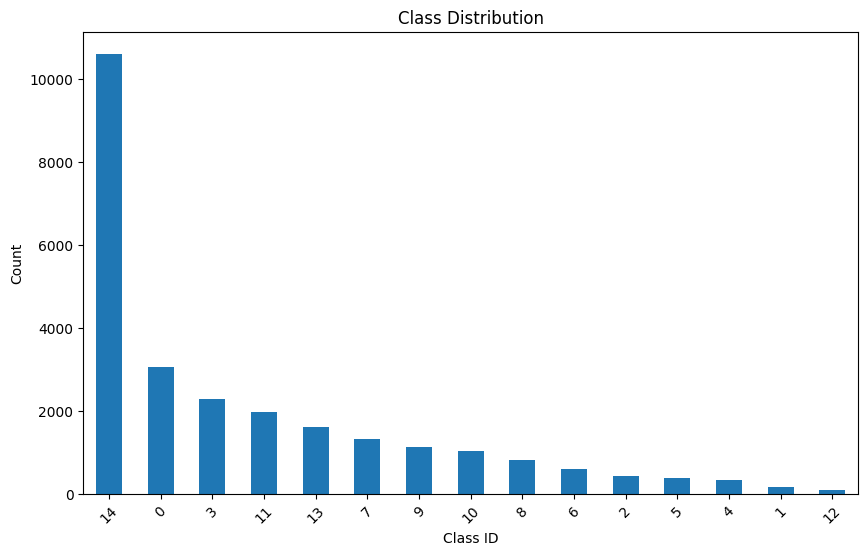

In [7]:
def read_csv():
    seed_everything(config.seed)
    df = pd.read_csv("/home/ttban9527/vinbigdata/train.csv")
    train_df = df.groupby(['image_id', 'class_id']).first().reset_index()
    return train_df

train_df = read_csv()
class_distribution = train_df['class_id'].value_counts()
print(class_distribution)
print(train_df.shape[0])

# 繪製長條圖
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [8]:
def merged_df(df):
    seed_everything(config.seed)
    merged_df = df.groupby('image_id')['class_id'].apply(lambda x: np.unique(x)).reset_index()

    # 將 class_id 轉換為數字類型，並排序
    label_names = sorted(df['class_id'].unique())

    # 將排序後的數字類型轉換為字串類型
    label_names = [str(class_id) for class_id in label_names]

    label_columns = [str(label) for label in label_names]  # 將 class_id 轉換為字符串形式
    label_data = np.zeros((len(merged_df), len(label_columns)))
    label_df = pd.DataFrame(label_data, columns=label_columns)

    # 將合併後的 class_id 列轉換為多標籤形式並填充到新的 DataFrame 中
    for i, labels in enumerate(merged_df['class_id']):
        label_df.loc[i, [str(label) for label in labels]] = 1

    # 將新的 DataFrame 連接到 merged_df 中
    merged_df = pd.concat([merged_df, label_df], axis=1)

    # 最後，移除原始的 class_id 列
    merged_df.drop(columns=['class_id'], inplace=True)
    merged_df = merged_df.drop(columns=['14'])

    return merged_df

# Transform

In [9]:
def get_transforms(train=False):
    
    if train:
        transform = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.3),
            A.Normalize(mean=[0.5488, 0.5488, 0.5488], std=[0.2495, 0.2495, 0.2495]),
            ToTensorV2()
        ], additional_targets={'image': 'image'})
    else:
        transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.5488, 0.5488, 0.5488], std=[0.2495, 0.2495, 0.2495]),
            ToTensorV2()
        ], additional_targets={'image': 'image'})
    
    return transform

def get_advtransforms(train=False):
    
    if train:
        transform = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.3),
            ToTensorV2()
        ], additional_targets={'image': 'image'})
    else:
        transform = A.Compose([
            A.Resize(224, 224),
            ToTensorV2()
        ], additional_targets={'image': 'image'})
    
    return transform

# 畫出15種類別的第一張 image 位置(未攻擊的)

temp = train_df[train_df["class_id"].duplicated() == False]
rows, cols = 8, 4
fig = plt.figure(figsize=(32, 64))

attacker = NoOpAttacker()
#attacker = PGDAttacker(1, 1, 1, device=config.device)

model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, 14)
model.to(config.device)
model.eval() 

transform = get_transforms(train=False)

for i in range(min(rows * cols, len(temp))):
    filename = "/" + temp.iloc[i, 0] + ".png"
    image_path = config.root + filename

    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(image=np.array(img))['image'].unsqueeze(0).to(config.device)

    label = torch.zeros((1, 14)).to(config.device)
    
    adv_img = attacker.attack(img_tensor, label, model)
    
    # 檢查返回值是否一致
    assert torch.equal(img_tensor, adv_img), "NoOpAttacker modified the input!"

    adv_img = adv_img.squeeze().detach().cpu().numpy()
    if adv_img.ndim == 3:
        adv_img = adv_img.transpose(1, 2, 0)

    ax1 = fig.add_subplot(rows, cols * 2, i * 2 + 1)
    ax1.imshow(img)  # 原圖
    ax1.set_title("Original")
    ax1.axis("off")

    ax2 = fig.add_subplot(rows, cols * 2, i * 2 + 2)
    ax2.imshow(adv_img)  # 對抗圖像
    ax2.set_title("Adversarial")
    ax2.axis("off")

plt.tight_layout()
plt.show()


# 畫出15種類別的第一張 image 位置(有攻擊的)

temp = train_df[train_df["class_id"].duplicated() == False]
rows, cols = 8, 4
fig = plt.figure(figsize=(32, 64))

#attacker = NoOpAttacker()
attacker = PGDAttacker(10, 50, 5, device=config.device)

model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, 14)
model.to(config.device)
model.eval() 

transform = get_transforms(train=False)

for i in range(min(rows * cols, len(temp))):
    filename = "/" + temp.iloc[i, 0] + ".png"
    image_path = config.root + filename

    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(image=np.array(img))['image'].unsqueeze(0).to(config.device)

    label = torch.zeros((1, 14)).to(config.device)
    
    adv_img = attacker.attack(img_tensor, label, model)
    
    # 檢查返回值是否一致
    #assert torch.equal(img_tensor, adv_img), "NoOpAttacker modified the input!"

    adv_img = adv_img.squeeze().detach().cpu().numpy()
    if adv_img.ndim == 3:
        adv_img = adv_img.transpose(1, 2, 0)

    ax1 = fig.add_subplot(rows, cols * 2, i * 2 + 1)
    ax1.imshow(img)  # 原圖
    ax1.set_title("Original")
    ax1.axis("off")

    ax2 = fig.add_subplot(rows, cols * 2, i * 2 + 2)
    ax2.imshow(adv_img)  # 對抗圖像
    ax2.set_title("Adversarial")
    ax2.axis("off")

plt.tight_layout()
plt.show()


# ResNet50

In [10]:
from torchsummary import summary
model = torchvision.models.resnet50(weights='IMAGENET1K_V1', progress = True)
model.fc = nn.Linear(2048, 14)
model.to(config.device)
summary(model, (3,224,224))
del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# DeiT

In [11]:
model = timm.create_model('deit3_small_patch16_224_in21ft1k', pretrained=True)
model.head = nn.Linear(384, 14)
model.to(config.device)
summary(model, (3,224,224))
del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
           Dropout-4             [-1, 197, 384]               0
          Identity-5             [-1, 197, 384]               0
          Identity-6             [-1, 197, 384]               0
         LayerNorm-7             [-1, 197, 384]             768
            Linear-8            [-1, 197, 1152]         443,520
          Identity-9           [-1, 6, 197, 64]               0
         Identity-10           [-1, 6, 197, 64]               0
           Linear-11             [-1, 197, 384]         147,840
          Dropout-12             [-1, 197, 384]               0
        Attention-13             [-1, 197, 384]               0
       LayerScale-14             [-1, 1

# Iterative train test split

In [12]:
def data_split(train_df, train_ratio, valid_ratio, test_ratio):
    assert train_ratio + valid_ratio + test_ratio == 1, "分配比例之和必須等於 1"
    seed_everything(config.seed)
    
    binarizer = MultiLabelBinarizer()
    disease_id = []

    # 構建每個圖像對應的疾病類別列表
    for image_id in train_df.image_id.unique():
        diseases = []
        temp = train_df[train_df["image_id"] == image_id]
        diseases.extend(list(temp["class_id"]))
        disease_id.append(diseases)

    # 將疾病類別進行 one-hot 編碼
    one_hot = binarizer.fit_transform(disease_id)
    
    # 第一步：劃分為訓練集和剩餘部分
    train_size = train_ratio
    remaining_size = 1 - train_size
    
    train_ID, train_label, remaining_ID, remaining_label = iterative_train_test_split(
        np.expand_dims(train_df["image_id"].unique(), axis=1),
        one_hot,
        test_size=remaining_size
    )
    
    # 第二步：劃分剩餘部分為驗證集和測試集
    valid_size = valid_ratio / (valid_ratio + test_ratio)  # 調整比例
    val_ID, val_label, test_ID, test_label = iterative_train_test_split(
        remaining_ID,
        remaining_label,
        test_size=(1 - valid_size)
    )
    
    # 構建訓練、驗證和測試數據集
    training = train_df[train_df["image_id"].isin(train_ID.ravel())]
    validation = train_df[train_df["image_id"].isin(val_ID.ravel())]
    testing = train_df[train_df["image_id"].isin(test_ID.ravel())]
    
    return training, validation, testing

# Training

In [13]:
class CustomDataset(Dataset):
    def __init__(self, root, df, transform=None):
        self.root = config.root
        self.data = df
        self.transform = transform
        self.device = config.device
        self.labels = df.iloc[:, 1:].values.astype(int)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        targets = self.labels[idx]
        targets = torch.tensor(targets, dtype=torch.float32)
        
        filename = "/" + self.data.iloc[idx, 0] + ".png"
        image_path = self.root + filename
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        image = image.float()
            
        return image, targets

In [14]:
class AdvCustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root  
        self.data = pd.read_csv(root + "annotations.csv")
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_id = str(self.data.iloc[idx, 0])  # 獲取 image_id
        target = torch.tensor(eval(self.data.iloc[idx, 1]), dtype=torch.float32).squeeze(0)  # 讀取標籤
        
        # 讀取圖片
        image_path = os.path.join(self.root, f"{image_id}.png")
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        return image, target

In [15]:
def train_one_epoch(model, train_loader, optimizer, scheduler, device, criterion):
    
    model.train()
    train_loss = []
    train_preds = []
    train_targets = []
    
    for images, targets in tqdm(train_loader):
        images = images.to(device).float()
        targets = targets.to(device).float()
        
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, targets)
        total_loss = loss.item()
        train_loss.append(total_loss)
        
        predicted = torch.round(torch.sigmoid(outputs))
        train_preds.extend(predicted.cpu().tolist())
        train_targets.extend(targets.cpu().tolist())
        
        loss.backward()
        optimizer.step()
        
    scheduler.step()
        
    train_loss = sum(train_loss) / len(train_loss)
    
    return train_loss, train_preds, train_targets

# Validation

In [16]:
@torch.no_grad()
def validation(model, val_loader, device, criterion):
    
    model.eval()
    val_loss = []
    val_preds = []
    val_targets = []

    for images, targets in tqdm(val_loader):
        images = images.to(device).float()
        targets = targets.to(device).float()
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        total_loss = loss.item()
        val_loss.append(total_loss)
        
        predicted = torch.round(torch.sigmoid(outputs))
        val_preds.extend(predicted.cpu().tolist())
        val_targets.extend(targets.cpu().tolist())
    
    val_loss = sum(val_loss) / len(val_loss)
    
    return val_loss, val_preds, val_targets

# Testing

In [17]:
def testing(model, test_loader, device):
    model.eval()
    test_probs = []  # 儲存機率分數
    test_preds = []  # 儲存 0/1 預測結果
    test_targets = []

    for images, targets in tqdm(test_loader):
        images = images.to(device).float()
        targets = targets.to(device).float()
        
        outputs = model(images)
        probs = torch.sigmoid(outputs)  # **取得機率**
        predicted = torch.round(probs)  # **轉為 0/1**

        test_probs.extend(probs.cpu().tolist())  # 儲存機率
        test_preds.extend(predicted.cpu().tolist())  # 儲存 0/1 預測
        test_targets.extend(targets.cpu().tolist())

    return test_probs, test_preds, test_targets

# Evaluator

In [18]:
def evaluator(preds, targets):
    preds = np.array(preds).astype(int)
    targets = np.array(targets).astype(int)

    # 確認 preds.shape[1] 來自你的標籤數量
    num_labels = preds.shape[1]
    label_names = [str(i) for i in range(num_labels)]

    acc = accuracy_score(targets, preds)  # accuracy_score 仍適用
    precision = precision_score(targets, preds, average="samples", zero_division=0)
    recall = recall_score(targets, preds, average="samples", zero_division=0)
    f1 = f1_score(targets, preds, average="samples", zero_division=0)
    jaccard = jaccard_score(targets, preds, average="samples")

    report = classification_report(targets, preds, target_names=label_names, zero_division=0)

    return acc, precision, recall, f1, report, jaccard

In [19]:
def AUROC(preds, targets):
    preds = np.array(preds)
    targets = np.array(targets)
    
    n_classes = preds.shape[1]
    roc_auc_values = []
    
    # **忽略 class 14 (no finding)**
    for i in range(n_classes):  # 只計算前 14 類別
        if np.sum(targets[:, i]) == 0:  # 避免某類別完全沒有樣本，導致 roc_auc_score 出錯
            continue
        
        roc_auc = roc_auc_score(targets[:, i], preds[:, i])
        roc_auc_values.append(roc_auc)

        fpr, tpr, _ = roc_curve(targets[:, i], preds[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {i} (area = {roc_auc:.2f})')
    
    # **計算平均 AUROC**
    mean_auc = np.mean(roc_auc_values) if roc_auc_values else 0.0

    # **繪製 ROC 曲線**
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for multi-label classification')
    plt.legend(loc="lower right")
    plt.show()
    
    return mean_auc

# FocalLoss

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, class_weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # 可以是 float 或 tensor
        self.gamma = gamma
        self.class_weight = class_weight  # 可以是 None 或 per-class tensor
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 確保 class_weight 轉換到 GPU
        class_weight = self.class_weight.to(inputs.device) if self.class_weight is not None else None
        alpha = self.alpha.to(inputs.device) if isinstance(self.alpha, torch.Tensor) else self.alpha

        # 計算 BCE loss
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, pos_weight=class_weight, reduction='none')

        # 計算 pt (更穩定的方式)
        pt = torch.sigmoid(inputs) * targets + (1 - torch.sigmoid(inputs)) * (1 - targets)

        # 計算 Focal Loss
        F_loss = alpha * (1 - pt) ** self.gamma * BCE_loss

        # 應用 reduction
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'batchmean':
            return F_loss.sum() / inputs.shape[0]
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss  # 'none' 直接返回 tensor

# Run

In [21]:
def Run():
    
    seed_everything(config.seed)
    device = config.device
    
    df_train = read_csv()
    train_df, valid_df, test_df = data_split(df_train, 0.7, 0.1, 0.2)
    
    filtered_class_counts = train_df[train_df["class_id"] != 14]["class_id"].value_counts().sort_index()
    
    print(f"Class的分布: {filtered_class_counts}")
    total_sum = train_df.shape[0]
    print(f"train_df總筆數: {total_sum}")
    non_class_num = total_sum - filtered_class_counts
    print(f"NonClass的分布: {non_class_num}")
    class_weight = non_class_num / filtered_class_counts
    class_weight = torch.tensor(class_weight, dtype=torch.float32)
    print(f"權重設定: {class_weight}")
    
    train_df = merged_df(train_df)
    valid_df = merged_df(valid_df)
    
    train_dataset = CustomDataset(root = config.root, df=train_df, transform=get_transforms(train=True))
    valid_dataset = CustomDataset(root = config.root, df=valid_df, transform=get_transforms(train=False))
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    
    criterion = FocalLoss(class_weight = class_weight).to(device)
    
    model = timm.create_model('deit3_small_patch16_224_in21ft1k', pretrained=True)
    model.head = nn.Linear(384, 14)
    model.to(device)
    
    parameters = [p for p in model.parameters() if p.requires_grad]
    
    optimizer = torch.optim.Adam(parameters, lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 12, gamma = config.gamma)
    
    best_val_jaccard = 0
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": [],
          "precision": [],
          "recall": [],
          "report": [],
          "jaccard": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": [],
          "precision": [],
          "recall": [],
          "report": [],
          "jaccard": []
      },
    }
    
    start_time = time.time()
    for epoch in range(config.epochs):
        train_loss, train_preds, train_targets = train_one_epoch(model, train_loader, optimizer, scheduler, device, criterion)
        train_acc, train_precision, train_recall, train_f1, train_report, train_jaccard = evaluator(train_preds, train_targets)
        val_loss, val_preds, val_targets = validation(model, val_loader, device, criterion)
        val_acc, val_precision, val_recall, val_f1, val_report, val_jaccard = evaluator(val_preds, val_targets)
        
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["precision"].append(train_precision)
        history["train"]["recall"].append(train_recall)
        history["train"]["report"].append(train_report)
        history["train"]["jaccard"].append(train_jaccard)
        
        history["valid"]["loss"].append(val_loss)
        history["valid"]["acc"].append(val_acc)
        history["valid"]["f1"].append(val_f1)
        history["valid"]["precision"].append(val_precision)
        history["valid"]["recall"].append(val_recall)
        history["valid"]["report"].append(val_report)
        history["valid"]["jaccard"].append(val_jaccard)
        
        print(f"Epoch [{epoch+1}/{config.epochs}]:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train Jaccard: {train_jaccard:.4f}")
        print(train_report)
        print(f"Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}, Valid F1: {val_f1:.4f}, Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid Jaccard: {val_jaccard:.4f}")
        print(val_report)
        if val_jaccard > best_val_jaccard:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_jaccard = val_jaccard
            torch.save(save_file, "DeiTcheckpoint.pth")
    
    end_time = time.time()
    total_time = end_time - start_time
    print(f"訓練時間： {total_time:.0f}秒")
    
    if torch.cuda.is_available():
        total_memory_allocated = torch.cuda.memory_allocated()
        print("記憶體使用:", total_memory_allocated)
    
    input_tensor = torch.randn((1, 3, 224, 224)).to(device)
    FLOPs, nparams = tp.utils.count_ops_and_params(model, input_tensor)
    print(f"模型的參數量：{nparams}")
    print(f"FLOPs: {FLOPs:.0f}" )
    
    best_ckpt = torch.load("DeiTcheckpoint.pth", map_location = device)
    model.load_state_dict(best_ckpt["model"])
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label = 'Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["jaccard"], label='Training Jaccard')
    plt.plot(range(config.epochs), history["valid"]["jaccard"], label='Validation Jaccard')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Jaccard Curves')
    plt.show()

Class的分布: class_id
0     2147
1      133
2      311
3     1610
4      243
5      273
6      429
7      905
8      577
9      796
10     708
11    1386
12      67
13    1132
Name: count, dtype: int64
train_df總筆數: 18141
NonClass的分布: class_id
0     15994
1     18008
2     17830
3     16531
4     17898
5     17868
6     17712
7     17236
8     17564
9     17345
10    17433
11    16755
12    18074
13    17009
Name: count, dtype: int64
權重設定: tensor([  7.4495, 135.3985,  57.3312,  10.2677,  73.6543,  65.4505,  41.2867,
         19.0453,  30.4402,  21.7902,  24.6229,  12.0887, 269.7612,  15.0256])


  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [1/20]:
Train Loss: 0.4268, Train Acc: 0.0383, Train F1: 0.1103, Train Precision: 0.0750, Train Recall: 0.2576, Train Jaccard: 0.0720
              precision    recall  f1-score   support

           0       0.25      0.88      0.39      2147
           1       0.01      0.79      0.03       133
           2       0.04      0.86      0.07       311
           3       0.19      0.93      0.31      1610
           4       0.03      0.85      0.06       243
           5       0.03      0.84      0.06       273
           6       0.05      0.87      0.09       429
           7       0.10      0.89      0.19       905
           8       0.06      0.88      0.12       577
           9       0.09      0.87      0.16       796
          10       0.08      0.85      0.14       708
          11       0.15      0.92      0.26      1386
          12       0.01      0.72      0.01        67
          13       0.13      0.89      0.22      1132

   micro avg       0.09      0.89      0.16     

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [2/20]:
Train Loss: 0.3303, Train Acc: 0.3208, Train F1: 0.1078, Train Precision: 0.0728, Train Recall: 0.2584, Train Jaccard: 0.0707
              precision    recall  f1-score   support

           0       0.37      0.90      0.52      2147
           1       0.03      0.90      0.05       133
           2       0.05      0.88      0.10       311
           3       0.27      0.90      0.42      1610
           4       0.05      0.93      0.10       243
           5       0.05      0.89      0.09       273
           6       0.08      0.90      0.14       429
           7       0.17      0.91      0.28       905
           8       0.10      0.90      0.18       577
           9       0.14      0.90      0.24       796
          10       0.13      0.90      0.22       708
          11       0.23      0.91      0.37      1386
          12       0.01      0.87      0.02        67
          13       0.20      0.90      0.32      1132

   micro avg       0.14      0.90      0.24     

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [3/20]:
Train Loss: 0.2819, Train Acc: 0.4601, Train F1: 0.1114, Train Precision: 0.0750, Train Recall: 0.2672, Train Jaccard: 0.0732
              precision    recall  f1-score   support

           0       0.43      0.94      0.59      2147
           1       0.03      0.90      0.07       133
           2       0.06      0.94      0.11       311
           3       0.33      0.93      0.48      1610
           4       0.06      0.92      0.12       243
           5       0.06      0.92      0.11       273
           6       0.10      0.93      0.18       429
           7       0.20      0.94      0.33       905
           8       0.12      0.93      0.21       577
           9       0.16      0.93      0.27       796
          10       0.17      0.92      0.29       708
          11       0.28      0.92      0.43      1386
          12       0.01      0.88      0.03        67
          13       0.24      0.92      0.37      1132

   micro avg       0.17      0.93      0.28     

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [4/20]:
Train Loss: 0.2613, Train Acc: 0.4924, Train F1: 0.1150, Train Precision: 0.0779, Train Recall: 0.2691, Train Jaccard: 0.0762
              precision    recall  f1-score   support

           0       0.46      0.95      0.62      2147
           1       0.04      0.92      0.07       133
           2       0.06      0.93      0.12       311
           3       0.37      0.93      0.52      1610
           4       0.07      0.94      0.13       243
           5       0.06      0.92      0.12       273
           6       0.11      0.94      0.20       429
           7       0.22      0.94      0.36       905
           8       0.13      0.95      0.23       577
           9       0.17      0.94      0.29       796
          10       0.19      0.93      0.32       708
          11       0.30      0.93      0.46      1386
          12       0.02      0.87      0.04        67
          13       0.25      0.94      0.39      1132

   micro avg       0.18      0.94      0.31     

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [5/20]:
Train Loss: 0.2703, Train Acc: 0.4653, Train F1: 0.1162, Train Precision: 0.0798, Train Recall: 0.2669, Train Jaccard: 0.0773
              precision    recall  f1-score   support

           0       0.46      0.94      0.62      2147
           1       0.03      0.90      0.07       133
           2       0.06      0.94      0.12       311
           3       0.37      0.93      0.53      1610
           4       0.07      0.95      0.13       243
           5       0.06      0.93      0.11       273
           6       0.11      0.93      0.20       429
           7       0.22      0.91      0.35       905
           8       0.12      0.93      0.22       577
           9       0.17      0.92      0.29       796
          10       0.18      0.91      0.30       708
          11       0.30      0.92      0.45      1386
          12       0.02      0.93      0.03        67
          13       0.24      0.93      0.39      1132

   micro avg       0.18      0.93      0.30     

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [6/20]:
Train Loss: 0.2400, Train Acc: 0.5248, Train F1: 0.1182, Train Precision: 0.0809, Train Recall: 0.2704, Train Jaccard: 0.0789
              precision    recall  f1-score   support

           0       0.49      0.95      0.65      2147
           1       0.04      0.94      0.08       133
           2       0.07      0.95      0.13       311
           3       0.40      0.93      0.55      1610
           4       0.07      0.92      0.13       243
           5       0.08      0.93      0.14       273
           6       0.12      0.94      0.21       429
           7       0.24      0.95      0.38       905
           8       0.13      0.94      0.23       577
           9       0.19      0.95      0.31       796
          10       0.19      0.94      0.32       708
          11       0.32      0.95      0.48      1386
          12       0.02      0.97      0.05        67
          13       0.26      0.95      0.41      1132

   micro avg       0.20      0.94      0.33     

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [7/20]:
Train Loss: 0.2115, Train Acc: 0.5663, Train F1: 0.1235, Train Precision: 0.0847, Train Recall: 0.2739, Train Jaccard: 0.0830
              precision    recall  f1-score   support

           0       0.55      0.96      0.70      2147
           1       0.06      0.96      0.11       133
           2       0.08      0.95      0.14       311
           3       0.44      0.96      0.60      1610
           4       0.09      0.95      0.17       243
           5       0.08      0.94      0.15       273
           6       0.14      0.96      0.24       429
           7       0.26      0.95      0.41       905
           8       0.15      0.96      0.26       577
           9       0.21      0.96      0.34       796
          10       0.22      0.94      0.35       708
          11       0.35      0.96      0.52      1386
          12       0.03      0.94      0.05        67
          13       0.29      0.95      0.44      1132

   micro avg       0.23      0.96      0.36     

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [8/20]:
Train Loss: 0.1994, Train Acc: 0.5716, Train F1: 0.1267, Train Precision: 0.0876, Train Recall: 0.2752, Train Jaccard: 0.0856
              precision    recall  f1-score   support

           0       0.56      0.96      0.71      2147
           1       0.06      0.98      0.12       133
           2       0.08      0.96      0.15       311
           3       0.45      0.95      0.62      1610
           4       0.11      0.95      0.20       243
           5       0.08      0.94      0.15       273
           6       0.14      0.96      0.25       429
           7       0.27      0.96      0.42       905
           8       0.15      0.96      0.26       577
           9       0.21      0.96      0.34       796
          10       0.24      0.96      0.38       708
          11       0.36      0.96      0.52      1386
          12       0.03      0.96      0.06        67
          13       0.29      0.96      0.45      1132

   micro avg       0.23      0.96      0.38     

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [9/20]:
Train Loss: 0.2125, Train Acc: 0.5513, Train F1: 0.1266, Train Precision: 0.0877, Train Recall: 0.2750, Train Jaccard: 0.0855
              precision    recall  f1-score   support

           0       0.56      0.96      0.71      2147
           1       0.06      0.95      0.11       133
           2       0.08      0.96      0.15       311
           3       0.45      0.94      0.61      1610
           4       0.11      0.96      0.19       243
           5       0.09      0.94      0.16       273
           6       0.14      0.96      0.25       429
           7       0.26      0.95      0.41       905
           8       0.15      0.96      0.25       577
           9       0.20      0.97      0.34       796
          10       0.22      0.95      0.35       708
          11       0.35      0.97      0.52      1386
          12       0.03      0.94      0.05        67
          13       0.28      0.96      0.43      1132

   micro avg       0.23      0.96      0.37     

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [10/20]:
Train Loss: 0.1905, Train Acc: 0.5925, Train F1: 0.1299, Train Precision: 0.0900, Train Recall: 0.2788, Train Jaccard: 0.0883
              precision    recall  f1-score   support

           0       0.57      0.97      0.72      2147
           1       0.07      0.98      0.13       133
           2       0.09      0.97      0.16       311
           3       0.47      0.97      0.63      1610
           4       0.12      0.96      0.21       243
           5       0.09      0.95      0.17       273
           6       0.16      0.96      0.28       429
           7       0.27      0.97      0.42       905
           8       0.15      0.97      0.27       577
           9       0.21      0.96      0.34       796
          10       0.24      0.95      0.38       708
          11       0.36      0.96      0.52      1386
          12       0.04      0.97      0.08        67
          13       0.30      0.96      0.46      1132

   micro avg       0.25      0.96      0.39    

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [11/20]:
Train Loss: 0.1686, Train Acc: 0.6124, Train F1: 0.1367, Train Precision: 0.0965, Train Recall: 0.2779, Train Jaccard: 0.0945
              precision    recall  f1-score   support

           0       0.60      0.97      0.74      2147
           1       0.09      0.97      0.17       133
           2       0.09      0.97      0.17       311
           3       0.51      0.97      0.67      1610
           4       0.16      0.98      0.28       243
           5       0.11      0.95      0.19       273
           6       0.17      0.94      0.28       429
           7       0.30      0.96      0.45       905
           8       0.17      0.97      0.29       577
           9       0.23      0.96      0.37       796
          10       0.26      0.96      0.41       708
          11       0.39      0.97      0.55      1386
          12       0.06      0.97      0.11        67
          13       0.32      0.95      0.48      1132

   micro avg       0.28      0.97      0.43    

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [12/20]:
Train Loss: 0.1748, Train Acc: 0.6037, Train F1: 0.1366, Train Precision: 0.0963, Train Recall: 0.2791, Train Jaccard: 0.0944
              precision    recall  f1-score   support

           0       0.59      0.97      0.73      2147
           1       0.08      0.98      0.16       133
           2       0.09      0.97      0.17       311
           3       0.49      0.97      0.65      1610
           4       0.15      0.98      0.27       243
           5       0.11      0.96      0.20       273
           6       0.18      0.97      0.30       429
           7       0.30      0.98      0.45       905
           8       0.17      0.96      0.28       577
           9       0.23      0.97      0.37       796
          10       0.26      0.96      0.40       708
          11       0.39      0.97      0.55      1386
          12       0.04      0.96      0.08        67
          13       0.32      0.96      0.48      1132

   micro avg       0.27      0.97      0.42    

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [13/20]:
Train Loss: 0.1413, Train Acc: 0.6533, Train F1: 0.1401, Train Precision: 0.0979, Train Recall: 0.2843, Train Jaccard: 0.0968
              precision    recall  f1-score   support

           0       0.64      0.99      0.78      2147
           1       0.11      1.00      0.19       133
           2       0.11      0.98      0.19       311
           3       0.55      0.98      0.71      1610
           4       0.16      1.00      0.27       243
           5       0.13      0.99      0.22       273
           6       0.21      0.98      0.35       429
           7       0.32      0.98      0.48       905
           8       0.18      0.99      0.30       577
           9       0.25      0.98      0.40       796
          10       0.31      0.97      0.46       708
          11       0.42      0.98      0.59      1386
          12       0.04      1.00      0.08        67
          13       0.35      0.97      0.52      1132

   micro avg       0.30      0.98      0.46    

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [14/20]:
Train Loss: 0.1270, Train Acc: 0.6682, Train F1: 0.1490, Train Precision: 0.1065, Train Recall: 0.2848, Train Jaccard: 0.1053
              precision    recall  f1-score   support

           0       0.68      0.99      0.80      2147
           1       0.13      0.98      0.23       133
           2       0.12      0.99      0.21       311
           3       0.58      0.98      0.73      1610
           4       0.20      0.99      0.33       243
           5       0.16      0.99      0.27       273
           6       0.24      0.98      0.38       429
           7       0.34      0.98      0.50       905
           8       0.19      0.99      0.32       577
           9       0.26      0.98      0.41       796
          10       0.33      0.97      0.49       708
          11       0.43      0.99      0.60      1386
          12       0.07      0.99      0.12        67
          13       0.37      0.98      0.53      1132

   micro avg       0.33      0.98      0.49    

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [15/20]:
Train Loss: 0.1189, Train Acc: 0.6756, Train F1: 0.1551, Train Precision: 0.1123, Train Recall: 0.2856, Train Jaccard: 0.1112
              precision    recall  f1-score   support

           0       0.68      0.99      0.80      2147
           1       0.17      1.00      0.29       133
           2       0.13      0.98      0.22       311
           3       0.60      0.98      0.75      1610
           4       0.24      1.00      0.38       243
           5       0.18      1.00      0.31       273
           6       0.25      0.98      0.40       429
           7       0.36      0.98      0.53       905
           8       0.20      0.99      0.33       577
           9       0.27      0.99      0.42       796
          10       0.34      0.97      0.50       708
          11       0.44      0.99      0.61      1386
          12       0.09      1.00      0.16        67
          13       0.38      0.98      0.54      1132

   micro avg       0.35      0.99      0.51    

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [16/20]:
Train Loss: 0.1144, Train Acc: 0.6783, Train F1: 0.1598, Train Precision: 0.1172, Train Recall: 0.2859, Train Jaccard: 0.1162
              precision    recall  f1-score   support

           0       0.68      0.99      0.81      2147
           1       0.18      0.99      0.31       133
           2       0.13      0.99      0.23       311
           3       0.61      0.98      0.75      1610
           4       0.27      1.00      0.42       243
           5       0.20      0.99      0.33       273
           6       0.25      0.98      0.40       429
           7       0.36      0.99      0.53       905
           8       0.21      0.98      0.34       577
           9       0.28      0.99      0.43       796
          10       0.35      0.98      0.52       708
          11       0.44      0.99      0.61      1386
          12       0.11      1.00      0.19        67
          13       0.38      0.98      0.55      1132

   micro avg       0.36      0.99      0.53    

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [17/20]:
Train Loss: 0.1101, Train Acc: 0.6822, Train F1: 0.1622, Train Precision: 0.1195, Train Recall: 0.2855, Train Jaccard: 0.1184
              precision    recall  f1-score   support

           0       0.69      0.99      0.81      2147
           1       0.20      0.98      0.33       133
           2       0.14      0.99      0.25       311
           3       0.64      0.98      0.77      1610
           4       0.27      0.99      0.42       243
           5       0.21      0.99      0.34       273
           6       0.27      0.99      0.42       429
           7       0.37      0.99      0.54       905
           8       0.21      0.98      0.35       577
           9       0.28      0.99      0.43       796
          10       0.38      0.98      0.54       708
          11       0.45      0.99      0.62      1386
          12       0.12      1.00      0.22        67
          13       0.38      0.98      0.55      1132

   micro avg       0.37      0.99      0.54    

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [18/20]:
Train Loss: 0.1028, Train Acc: 0.6902, Train F1: 0.1682, Train Precision: 0.1256, Train Recall: 0.2865, Train Jaccard: 0.1248
              precision    recall  f1-score   support

           0       0.70      0.99      0.82      2147
           1       0.24      1.00      0.39       133
           2       0.15      0.98      0.27       311
           3       0.65      0.99      0.78      1610
           4       0.29      0.99      0.45       243
           5       0.24      0.99      0.38       273
           6       0.28      0.99      0.44       429
           7       0.38      0.99      0.55       905
           8       0.22      0.99      0.36       577
           9       0.29      0.99      0.45       796
          10       0.40      0.98      0.57       708
          11       0.46      0.99      0.63      1386
          12       0.14      1.00      0.24        67
          13       0.40      0.98      0.56      1132

   micro avg       0.39      0.99      0.56    

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [19/20]:
Train Loss: 0.0984, Train Acc: 0.6930, Train F1: 0.1725, Train Precision: 0.1299, Train Recall: 0.2873, Train Jaccard: 0.1292
              precision    recall  f1-score   support

           0       0.70      0.99      0.82      2147
           1       0.27      1.00      0.42       133
           2       0.17      0.99      0.29       311
           3       0.65      0.98      0.79      1610
           4       0.32      1.00      0.48       243
           5       0.27      1.00      0.42       273
           6       0.29      0.99      0.45       429
           7       0.40      0.99      0.57       905
           8       0.23      0.99      0.37       577
           9       0.29      0.99      0.45       796
          10       0.42      0.99      0.59       708
          11       0.47      0.99      0.63      1386
          12       0.16      1.00      0.28        67
          13       0.41      0.99      0.58      1132

   micro avg       0.40      0.99      0.57    

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [20/20]:
Train Loss: 0.0927, Train Acc: 0.6963, Train F1: 0.1775, Train Precision: 0.1355, Train Recall: 0.2877, Train Jaccard: 0.1347
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2147
           1       0.28      1.00      0.44       133
           2       0.19      0.99      0.31       311
           3       0.66      0.99      0.79      1610
           4       0.34      1.00      0.51       243
           5       0.30      1.00      0.46       273
           6       0.31      1.00      0.48       429
           7       0.41      0.99      0.58       905
           8       0.23      0.98      0.38       577
           9       0.30      0.99      0.47       796
          10       0.45      0.99      0.62       708
          11       0.47      0.99      0.64      1386
          12       0.18      1.00      0.31        67
          13       0.41      0.98      0.58      1132

   micro avg       0.42      0.99      0.59    

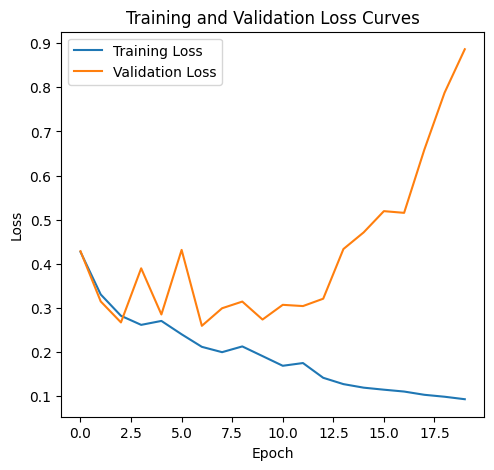

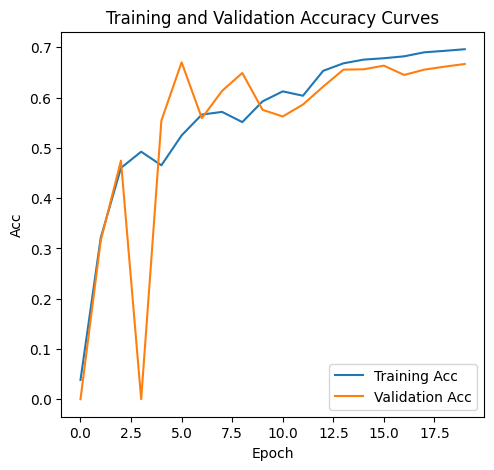

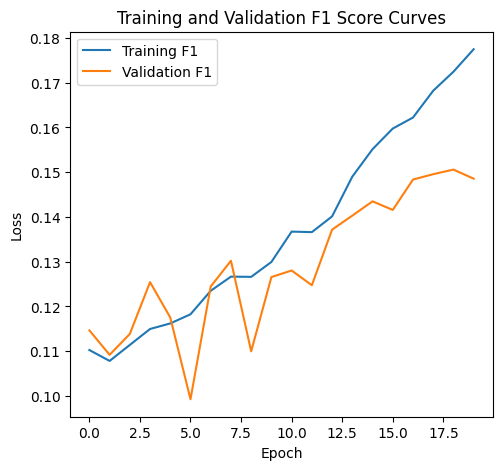

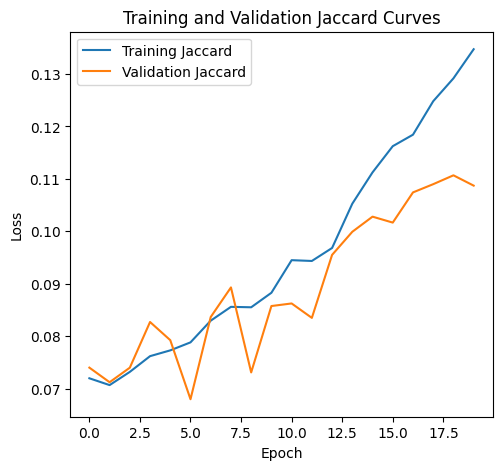

In [22]:
Run()

  0%|          | 0/101 [00:00<?, ?it/s]

Test Acc: 0.6758, Test F1: 0.1614, Test Precision: 0.1361, Test Recall: 0.2371, Test Jaccard: 0.1222
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       613
           1       0.29      0.57      0.38        35
           2       0.17      0.53      0.25        92
           3       0.65      0.91      0.76       460
           4       0.38      0.71      0.50        73
           5       0.27      0.74      0.39        76
           6       0.29      0.71      0.41       119
           7       0.42      0.75      0.54       277
           8       0.21      0.71      0.33       168
           9       0.28      0.78      0.41       224
          10       0.61      0.74      0.67       216
          11       0.46      0.85      0.60       396
          12       0.13      0.42      0.20        19
          13       0.39      0.81      0.52       320

   micro avg       0.43      0.82      0.56      3088
   macro avg       0.37      0.73

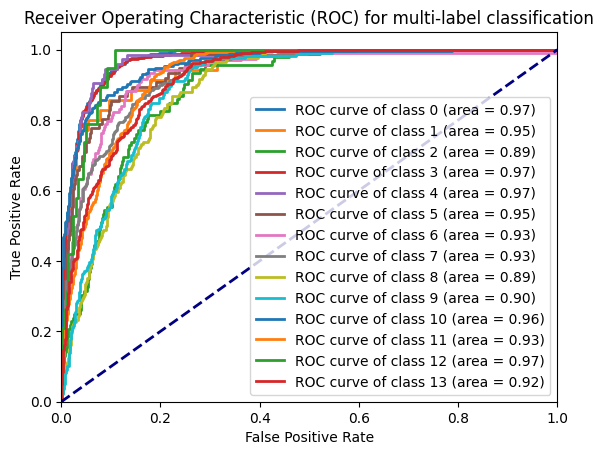

Mean AUROC: 0.9371


In [23]:
seed_everything(config.seed)
device = config.device

df_train = read_csv()
train_df, valid_df, test_df = data_split(df_train, 0.7, 0.1, 0.2)

test_df = merged_df(test_df)
test_dataset = CustomDataset(root = config.root, df=test_df, transform=get_transforms(train=False))
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# DeiTcheckpoint.pth
model = timm.create_model('deit3_small_patch16_224_in21ft1k', pretrained=True)
model.head = nn.Linear(384, 14)
model.to(device)
best_ckpt = torch.load("DeiTcheckpoint.pth", map_location = device)
model.load_state_dict(best_ckpt["model"])

test_probs, test_preds, test_targets = testing(model, test_loader, device)
test_acc, test_precision, test_recall, test_f1, test_report, test_jaccard = evaluator(test_preds, test_targets)

print(f"Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test Jaccard: {test_jaccard:.4f}")
print(test_report)

mean_auc = AUROC(test_probs, test_targets)
print(f"Mean AUROC: {mean_auc:.4f}")

In [ ]:
def Adv_Run():
    seed_everything(config.seed)
    device = config.device
    
    df_train = read_csv()
    train_df, valid_df, test_df = data_split(df_train, 0.7, 0.1, 0.2)
    
    filtered_class_counts = train_df[train_df["class_id"] != 14]["class_id"].value_counts().sort_index()
    
    print(f"Class的分布: {filtered_class_counts}")
    total_sum = train_df.shape[0]
    print(f"train_df總筆數: {total_sum}")
    non_class_num = total_sum - filtered_class_counts
    print(f"NonClass的分布: {non_class_num}")
    class_weight = non_class_num / filtered_class_counts
    class_weight = torch.tensor(class_weight, dtype=torch.float32)
    print(f"權重設定: {class_weight}")
    
    train_dataset = AdvCustomDataset(root="/home/ttban9527/PGD/deit/train" + config.att + "/",  transform=get_advtransforms(train=True))
    valid_dataset = AdvCustomDataset(root="/home/ttban9527/PGD/deit/valid/", transform=get_advtransforms(train=False))
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    
    criterion = FocalLoss(class_weight=class_weight).to(device)
    
    model = timm.create_model('deit3_small_patch16_224_in21ft1k', pretrained=True)
    model.head = nn.Linear(384, 14)
    model.to(device)
    best_ckpt = torch.load("AdvDeiTcheckpoint_" + config.att +".pth", map_location = device)
    model.load_state_dict(best_ckpt["model"])
    
    parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(parameters, lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=config.gamma)
    
    best_val_jaccard = 0
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": [],
          "precision": [],
          "recall": [],
          "report": [],
          "jaccard": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": [],
          "precision": [],
          "recall": [],
          "report": [],
          "jaccard": []
      },
    }
    
    #attacker = PGDAttacker(num_iter=5, epsilon=10, step_size=2, device=config.device)

    start_time = time.time()
    for epoch in range(config.epochs):
        train_loss, train_preds, train_targets = train_one_epoch(model, train_loader, optimizer, scheduler, device, criterion)
        train_acc, train_precision, train_recall, train_f1, train_report, train_jaccard = evaluator(train_preds, train_targets)
        val_loss, val_preds, val_targets = validation(model, val_loader, device, criterion)
        val_acc, val_precision, val_recall, val_f1, val_report, val_jaccard = evaluator(val_preds, val_targets)
        
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["train"]["precision"].append(train_precision)
        history["train"]["recall"].append(train_recall)
        history["train"]["report"].append(train_report)
        history["train"]["jaccard"].append(train_jaccard)
        
        history["valid"]["loss"].append(val_loss)
        history["valid"]["acc"].append(val_acc)
        history["valid"]["f1"].append(val_f1)
        history["valid"]["precision"].append(val_precision)
        history["valid"]["recall"].append(val_recall)
        history["valid"]["report"].append(val_report)
        history["valid"]["jaccard"].append(val_jaccard)
        
        print(f"Epoch [{epoch+1}/{config.epochs}]:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train Jaccard: {train_jaccard:.4f}")
        print(train_report)
        print(f"Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}, Valid F1: {val_f1:.4f}, Valid Precision: {val_precision:.4f}, Valid Recall: {val_recall:.4f}, Valid Jaccard: {val_jaccard:.4f}")
        print(val_report)
        if val_jaccard > best_val_jaccard:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_jaccard = val_jaccard
            torch.save(save_file, "AdvDeiTcheckpoint_" + config.att +".pth")
    
    end_time = time.time()
    total_time = end_time - start_time
    print(f"訓練時間： {total_time:.0f}秒")
    
    if torch.cuda.is_available():
        total_memory_allocated = torch.cuda.memory_allocated()
        print("記憶體使用:", total_memory_allocated)
    
    input_tensor = torch.randn((1, 3, 224, 224)).to(device)
    FLOPs, nparams = tp.utils.count_ops_and_params(model, input_tensor)
    print(f"模型的參數量：{nparams}")
    print(f"FLOPs: {FLOPs:.0f}" )
    
    best_ckpt = torch.load("AdvDeiTcheckpoint_" + config.att +".pth", map_location = device)
    model.load_state_dict(best_ckpt["model"])
        
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label = 'Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["jaccard"], label='Training Jaccard')
    plt.plot(range(config.epochs), history["valid"]["jaccard"], label='Validation Jaccard')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Jaccard Curves')
    plt.show()
    
    return total_time, total_memory_allocated, nparams, FLOPs

total_time, total_memory_allocated, nparams, FLOPs = Adv_Run()

print(f"訓練時間： {total_time:.0f}秒")
print("記憶體使用:", total_memory_allocated)
print(f"模型的參數量：{nparams}")
print(f"FLOPs: {FLOPs:.0f}" )

seed_everything(config.seed)
device = config.device

test_dataset = AdvCustomDataset(root="/home/ttban9527/PGD/deit/test/", transform=get_advtransforms(train=False))
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# DeiTcheckpoint.pth
model = timm.create_model('deit3_small_patch16_224_in21ft1k', pretrained=True)
model.head = nn.Linear(384, 14)
model.to(device)
best_ckpt = torch.load("AdvDeiTcheckpoint_" + config.att +".pth", map_location = device)
model.load_state_dict(best_ckpt["model"])

test_probs, test_preds, test_targets = testing(model, test_loader, device)
test_acc, test_precision, test_recall, test_f1, test_report, test_jaccard = evaluator(test_preds, test_targets)

print(f"Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test Jaccard: {test_jaccard:.4f}")
print(test_report)

mean_auc = AUROC(test_probs, test_targets)
print(f"Mean AUROC: {mean_auc:.4f}")